메모리 이슈로 인한 대대적인 수정......

solution dictionary

1.   chromosome (list) : 재학습할 레이어에 대한 정보 저장
2.   fitness (int) : 각 solutione들의 fitness 저장



# 모듈 임포트, 변수 선언

In [ ]:
import random

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, GlobalMaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
import random
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

In [ ]:
IMAGE_SIZE = (224, 224)
seed = 126
channels = 3

In [ ]:
chromosome_num = 154 #염색체 수 이번 프로젝트에서는 mobileNetV2의 레이어 수에 해당함
solution_num = 24 #한 세대 당 개체 수
solution_list = [] #solution들을 모아놓은 리스트
generation_limit = 20
generation = 1

In [ ]:
model_dir = '/content/drive/MyDrive/2024urop/model/ga/'

In [ ]:
np.random.seed(seed)
#random.seed(seed)
tf.random.set_seed(seed)

# 데이터 준비

In [ ]:
batch_size = 128

Number of images in training:  5712
Number of images in testing:  1311


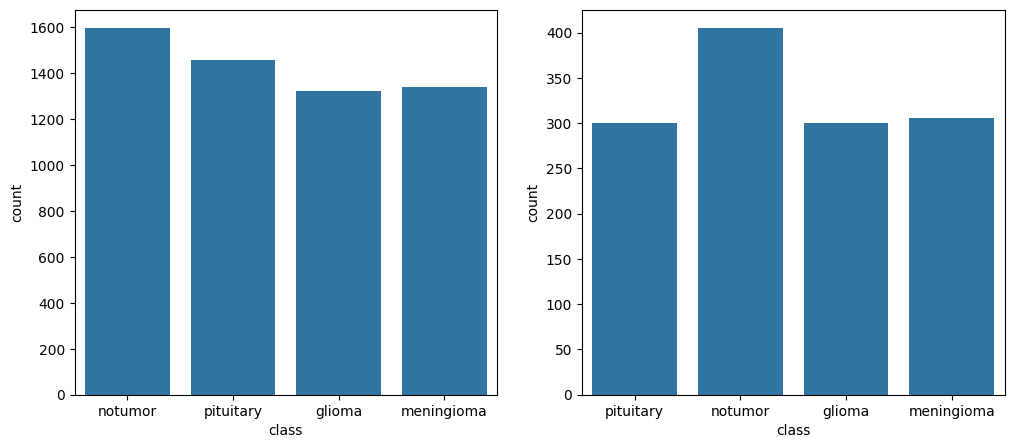

In [ ]:
root_path = '/content/drive/MyDrive/2024urop/dataset'
labels = []
trainFolder = root_path+'/Training/'
testFolder = root_path+'/Testing/'

quantity_tr = {}
quantity_te = {}
for folder in os.listdir(trainFolder):
    quantity_tr[folder] = len(os.listdir(trainFolder+folder))
    labels.append(folder)

for folder in os.listdir(testFolder):
    quantity_te[folder] = len(os.listdir(testFolder+folder))


quantity_train = pd.DataFrame(list(quantity_tr.items()),
                              index=range(0,len(quantity_tr)), columns=['class','count'])

quantity_test = pd.DataFrame(list(quantity_te.items()),
                              index=range(0,len(quantity_te)), columns=['class','count'])

figure, ax = plt.subplots(1,2,figsize=(12,5))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])

print("Number of images in training: ", sum(quantity_tr.values()))
print("Number of images in testing: ", sum(quantity_te.values()))

plt.show()

In [ ]:
labels

['notumor', 'pituitary', 'glioma', 'meningioma']

In [ ]:
# reading the dataset
X_train = []
y_train = []

X_test = []
y_test = []

for i in labels:
    folderPath = os.path.join(root_path,'Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j), 1)
        img = cv2.resize(img,(IMAGE_SIZE[0], IMAGE_SIZE[1]))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join(root_path,'Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j), 1)
        img = cv2.resize(img,(IMAGE_SIZE[0], IMAGE_SIZE[1]))
        X_test.append(img)
        y_test.append(i)

  1%|          | 16/1595 [00:29<48:10,  1.83s/it]


KeyboardInterrupt: 

In [ ]:
# python list to numpy array
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
# rescaling
X_train=X_train/255.0
X_test=X_test/255.0

In [ ]:
print(np.min(X_train), np.max(X_train))

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

In [ ]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

train_datagen = ImageDataGenerator(
        rotation_range=20,         # 이미지를 무작위로 0도에서 20도까지 회전
        width_shift_range=0.2,     # 이미지를 좌우로 무작위 이동 (전체 가로 길이의 20%까지)
        height_shift_range=0.2,    # 이미지를 위아래로 무작위 이동 (전체 세로 길이의 20%까지)
        shear_range=0.15,          # 이미지를 무작위로 전단 변환
        zoom_range=0.2,            # 이미지를 무작위로 확대/축소 (0.8배에서 1.2배 사이)
        horizontal_flip=True,      # 이미지를 수평으로 무작위 뒤집기
        fill_mode='nearest',
        validation_split = 0.2
)
test_datagen = ImageDataGenerator()


train_ds = train_datagen.flow(
  X_train, y_train,
  subset="training",
  shuffle=True,
  batch_size=batch_size)

In [ ]:
val_ds = train_datagen.flow(
  X_train, y_train,
  subset="validation",
  shuffle=True,
  batch_size=batch_size)

In [ ]:
test_ds = test_datagen.flow(
  X_test, y_test,
  shuffle=False,
  batch_size=batch_size)

In [ ]:
j = 0
class_mapping = {}
for i in labels:
    class_mapping[j] = i
    j+=1

class_mapping

In [ ]:
def show_few_images(number_of_examples=2, predict_using_model=None):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(testFolder)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(testFolder)):
        image_ids = os.listdir(os.path.join(testFolder,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:

            display = cv2.imread(os.path.join(testFolder,folder,image_ids[j]),1)
            display = cv2.resize(display, (IMAGE_SIZE[0], IMAGE_SIZE[1]))/255.0
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True: '+folder
            if(predict_using_model):
                result = predict_using_model.predict(np.array([display]))
                #print(result)
                acc = str(round(np.max(result)*100, 3))
                predicted_classname = class_mapping[np.argmax(result)]
                title = title+'\nPrediction : '+predicted_classname+" - "+acc+"%"
            ax1[axs].set_title(title)
            axs=axs+1

In [ ]:
show_few_images(3)

# ga 연산자 구현

In [ ]:
def encode(chromosome):
    # 정수 배열을 2진수 문자열로 변환
    bin_string = ''.join(map(str, chromosome))
    # 2진수 문자열을 16진수 문자열로 변환
    hex_string = hex(int(bin_string, 2))[2:]
    return hex_string
    #재학습 여부를 저장하는 0과 1이 저장된 bool 배열을


def decode(hex_string):
    # 16진수 문자열을 2진수 문자열로 변환
    bin_string = bin(int(hex_string, 16))[2:]  # 0b 접두사 제거
    bin_string.zfill(len(hex_string) * 4)
    chromosome = list(map(int, bin_string))
    return chromosome

In [ ]:
def compile_model(code):
  base_model = set_trainable_layer(code)
  model = Sequential([base_model,
                      Dense(16, activation = 'relu'),
                      Dropout(0.5),
                      Dense(4, activation = 'softmax')
                      ])
  model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.0001), metrics = ['accuracy'])
  #모델 컴파일
  modelname = 'ga' + code + '-bestmodel.keras'
  modelpath = os.path.join(model_dir, modelname)
  #각 해의 모델이 저장될 위치
  early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5)
  checkpointer = ModelCheckpoint(filepath = modelpath, monitor = 'val_accuracy', verbose = 1, save_best_only = True)
  history = model.fit(train_ds, validation_data = val_ds, epochs = 5, callbacks = [early_stopping, checkpointer])
  fitness = int(max(history.history['val_accuracy']) * 10000)

  return fitness

In [ ]:
def divide_set(p1, p2):
    k = 1  # 1-point crossover
    chromosome1 = decode(p1['chromosome'])
    chromosome2 = decode(p2['chromosome'])
    result = []

    # chromosome1과 chromosome2 중 더 짧은 쪽의 길이에 맞춰서 point를 설정
    point = random.randint(0, min(len(chromosome1), len(chromosome2)) - 1)

    # 반복문도 두 크로모좀 중 더 짧은 길이로 설정
    for i in range(min(len(chromosome1), len(chromosome2))):
        if k == 1:
            result.append(chromosome1[i])
            if i == point:
                k -= 1
        else:
            result.append(chromosome2[i])

        # 1-point crossover
        global generation
        std = random.uniform(0, 1)
        if std < 1 / generation * 10:  # non-uniform mutation
            if result[i] == 0:
                result[i] = 1
            else:
                result[i] = 0

    return encode(result)  # 부호화된 형태로 반환함


In [ ]:
def selection():
  fsum = 0
  minimum = 99999
  for i in solution_list:
    fsum += i['fitness']
    if i['fitness'] < minimum:
      min = i['fitness']

  std = random.randint(minimum, fsum-1)
  std *= (fsum - minimum)
  std = int(std + minimum)
  #fsum과 min 사이의 값을 정규분포를 따라 난수 고르기....

  temp = 0
  for i in solution_list:
    temp += i['fitness']
    if(temp > std):
      break
  return i

In [ ]:
def set_trainable_layer(code):
  base_model = MobileNetV2(include_top = False, weights = 'imagenet', input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1],channels), pooling = 'max')
  chromosome = decode(code)
  for i in chromosome:
    if chromosome[i] == 1 :
      base_model.layers[i].trainable = True
    else:
      base_model.layers[i].trainable = False

  return base_model

  #해에 따라서 학습 가능한 레이어 설정

In [ ]:
def crossover(solution_list):
  for p1 in solution_list:
    p2 = selection()
    code = divide_set(p1, p2)
    fitness = compile_model(code)
    dic = {'chromosome' : code, 'fitness' : fitness}
    solution_list.append(dic)
  return solution_list

In [ ]:
def getMinMax(solution_list):
  min = 99999
  max = -1

  for i in solution_list:
    if i['fitness'] < min:
      min = i['fitness']
    if i['fitness'] > max:
      max = i['fitness']

  return min, max

In [ ]:
def sorting(solution_list):
  min, max = getMinMax(solution_list)
  length = max-min

  counting = [0]*(length+1)

  for i in solution_list:
    counting[i['fitness'] - min] += 1

  for i in range(1, len(counting)):
    counting[i] += counting[i-1]

  result = [0] * len(solution_list)

  j = len(solution_list) -1
  while(j>=0):
    result[counting[solution_list[j]['fitness']-min]-1] = solution_list[j]
    counting[solution_list[j]['fitness']-min] -= 1
    j-=1

  return result

In [ ]:
def remove(solution_list):
  result = sorting(solution_list)
  result = result[:solution_num]

  return result


In [ ]:
def set_first_generation(solution_list):
  temp_arr = np.random.randint(0, 5000, solution_num)
  for i in temp_arr:
    #1세대 개체들의 경우 재현 가능하도록 solution 개수만큼 정수를 발생시켜
    #각각의 solution에 해당하는 정수가 seed 역할을 하도록....
    #이 randint 배열을 만들어내는 데 사용된 seed 값은 126
    np.random.seed(i)
    chromosome = np.random.randint(0,2, size = chromosome_num)
    #초기 해 랜덤 생성
    code = encode(chromosome)
    dic = {'chromosome' : code , 'fitness' : 0}
    solution_list.append(dic)

  for i in solution_list:
    #여기서 i는 딕셔너리 형태
    fitness = compile_model(i['chromosome'])
    i['fitness'] = fitness
    #초기 해 fitnes와 modelpath 설정

In [ ]:
def ga(solution_list):
  global generation
  print(generation, " generation")
  set_first_generation(solution_list)
  np.random.seed(seed)
  solution_list = sorting(solution_list)
  solution_list = remove(solution_list)
  maximum = open('/content/drive/MyDrive/2024urop/ga/max.txt', 'w')
  gen = open('/content/drive/MyDrive/2024urop/ga/generation.txt', 'w')

  maximum.write(solution_list[0]['chromosome'] + " : " + str(solution_list[0]['fitness']) + "\n")

  gen.write(str(generation) + " generation /n")
  for i in solution_list:
    gen.write(str(i['fitness']) + ", ")

  generation += 1

  while generation <= generation_limit:
    print(generation, " generation")
    solution_list = crossover(solution_list)
    solution_list = sorting(solution_list)
    solution_list = remove(solution_list)
    max.write(solution_list[0]['chromosome'] + " : " + str(solution_list[0]['fitness']) + "\n")
    for i in solution_list:
      gen.write(str(i['fitness']) + ", ")

    generation += 1
  maximum.close()
  gen.close()


In [ ]:
code = '19b07cc55df18600e275467e8b5699879e2025'
print(decode(code))

[1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]


# ga 실행

In [ ]:
ga(solution_list)

1  generation


KeyboardInterrupt: 

In [ ]:
best_chromosome = solution_list[0].chromosome
print(best_chromosome)

In [ ]:
print(decode(best_chromosome))

In [ ]:
best_solution = solution_list[0]

In [ ]:
print(best_solution.fitness)